In [1]:
import os
import matplotlib.image as img 
import numpy as np 
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import random
import cv2
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
 def detect_faces(cascade, test_image):
    # create a copy of the image to prevent any changes to the original one.
    image_copy = test_image.copy()

    #convert the test image to gray scale as opencv face detector expects gray images
    gray_image = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)

    # Applying the haar classifier to detect faces
    faces_rect = cascade.detectMultiScale(gray_image, scaleFactor=1.3,minNeighbors=3,minSize=(30, 30))

    for (x, y, w, h) in faces_rect:
        cv2.rectangle(image_copy, (x, y), (x+w, y+h), (0, 255, 0))
        image_copy = image_copy[y:y + h, x:x + w]
        try:
            image_copy = cv2.resize(image_copy, (250,250))
            return image_copy
        except:
            continue;
            
def process_data(dir): 
    gender = "";                                
    img_objs = [];                                                                
    for subdir, dirs, files in os.walk(dir):
        
        # check if picture is in female or male folder
        
            if ("female" in subdir):
                gender = "female"
            else:
                gender = "male"
                
            # go through image files and read each image
            images_arr = [];
            d = {};
            haar_cascade_face = cv2.CascadeClassifier('./data/haarcascade_frontalface_default.xml')
            for file in files:
                file_path = os.path.join(subdir, file)
                
                # read all image files, if it fails, specify what files failed
                try:
                    image = cv2.imread(file_path)
                    if image is not None:
                        image = detect_faces(haar_cascade_face, cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                        if image is not None:
                            images_arr.append(image[:, :, 0:3])
                except:
                    print("Could not read " + file_path)
                    
            # ignore the dirs that are not direct parent of img files
            if(len(subdir.split("/")) > 4):
                # zip key and values together
#                 print(subdir.split("/"))
                d["name"] = subdir.split("\\")[-1];
                d["gender"] = gender;
                d["images"] = images_arr;
                    
            # add each dictionary to list
            img_objs.append(d)
    return img_objs


path = "./data/faces94/"
img_info = process_data(path)
img_info = [i for i in img_info if i]

In [3]:
counter = 0;
for i in img_info:
    if i["gender"] == "female":
        counter += 1
print(counter)

20


In [100]:
for i in img_info:
    counter = 0
    for im in i["images"]:
        if(i["gender"] == "male"):
            counter += 1
            cv2.imwrite("./data/faces94Cropped/male/"+i["name"].split("/")[-1]+".jpg", cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        else:
            counter += 1
            cv2.imwrite("./data/faces94Cropped/female/"+i["name"].split("/")[-1]+".jpg", cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

In [4]:
labels = ["male", "female"]

males, females = [], [];
male_labels, female_labels = [], []

for info in img_info:
    if(info["gender"]=="male"):
        for i in info["images"]:
            males.append(i)
            male_labels.append(labels.index(info["gender"]))
    else:
        for i in info["images"]:
            females.append(i)
            female_labels.append(labels.index(info["gender"]))

    
# grab random men from the data set
rand_males = random.sample(males, 386) 
rand_labels = random.sample(male_labels, 386)

images, all_labels = np.array(females+rand_males), np.array(female_labels+rand_labels)
train_images, test_images, train_labels, test_labels = train_test_split(images, all_labels, train_size=0.5,test_size=0.5)
train_labels = train_labels.reshape(386, 1)
test_labels = train_labels.reshape(386, 1)

In [22]:
# print what percentage of males vs females
num_females = 0;
counter = 0;
for g in train_labels:
    num_females = g[0] + num_females
    
print("Percentage of females in training data set:", (num_females/(len(train_labels)))*100)
print(num_females)

Percentage of females in training data set: 47.40932642487047
183


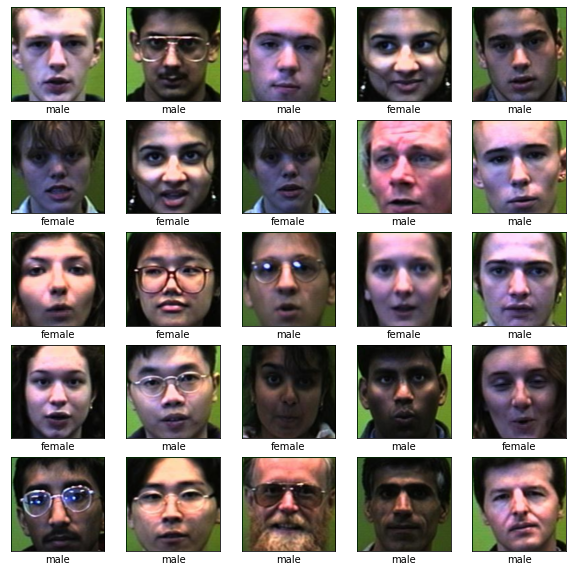

In [6]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(labels[train_labels[i][0]])
plt.show()

In [15]:
model = models.Sequential()
model.add(layers.Conv2D(96, (11, 11), activation='relu', input_shape=(250, 250, 3), strides=(4, 4)))
model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
model.add(layers.Conv2D(256, (5, 5), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((3, 3), strides=(2,2)))
model.add(layers.Conv2D(384, (3, 3), activation='relu', padding ='same'))
model.add(layers.Conv2D(384, (3, 3), activation='relu', padding ='same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding ='same'))
model.add(layers.MaxPooling2D((3, 3), strides=(2,2)))

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 60, 60, 96)        34944     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 256)       614656    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 384)       885120    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 384)       1327488   
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 256)      

In [17]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 60, 60, 96)        34944     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 256)       614656    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 384)       885120    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 384)       1327488   
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 256)      

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
13/13 [==============================] - 16s 1s/step - loss: 168.4540 - accuracy: 0.4508 - val_loss: 0.6953 - val_accuracy: 0.5155
Epoch 2/10
13/13 [==============================] - 17s 1s/step - loss: 0.6390 - accuracy: 0.6244 - val_loss: 0.7338 - val_accuracy: 0.4922
Epoch 3/10
13/13 [==============================] - 17s 1s/step - loss: 0.4803 - accuracy: 0.7850 - val_loss: 1.3614 - val_accuracy: 0.4741
Epoch 4/10
13/13 [==============================] - 17s 1s/step - loss: 0.2600 - accuracy: 0.8964 - val_loss: 2.4001 - val_accuracy: 0.4482
Epoch 5/10
13/13 [==============================] - 17s 1s/step - loss: 0.1938 - accuracy: 0.9352 - val_loss: 2.3506 - val_accuracy: 0.4404
Epoch 6/10
13/13 [==============================] - 18s 1s/step - loss: 0.1621 - accuracy: 0.9301 - val_loss: 2.2810 - val_accuracy: 0.4430
Epoch 7/10
13/13 [==============================] - 20s 2s/step - loss: 0.1463 - accuracy: 0.9430 - val_loss: 2.8926 - val_accuracy: 0.4534
Epoch 8/10
13/13 [

13/13 - 3s - loss: 2.4578 - accuracy: 0.4508


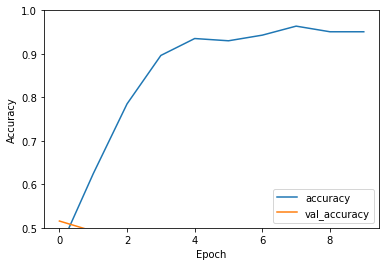

In [20]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [21]:
print(test_acc)

0.45077720284461975
